In [1]:
import sys
sys.path.append('../main/')
from multi_py.multi import *
# from multi_py.atmos import atmos
import matplotlib.pyplot as plt
plt.style.use('../main/multi_py/Bergemann2020.mplstyle')

In [2]:
# test_atmos = atmos(parent='../runs/SiStagNLTE_30_f3Dold/', file='multi3d.input')

In [3]:
major_krs = [286, 291, 293, 299, 427]
run_3DNLTE = m3d('../runs/SiStagNLTE_30_f3Dold/output/', lines=major_krs, conts=[], ratmos=True)
run_1DNLTE = m3d('../runs/SiMarcs1DNLTE/output/', lines=major_krs, conts=[], ratmos=True)

Completed reading parameters from ../runs/SiMarcs1DNLTE/output//


In [4]:
atmo_3DNLTE = run_3DNLTE.atmos
atmo_1DNLTE = run_1DNLTE.atmos

Text(0.5, 1.0, '1DNLTE')

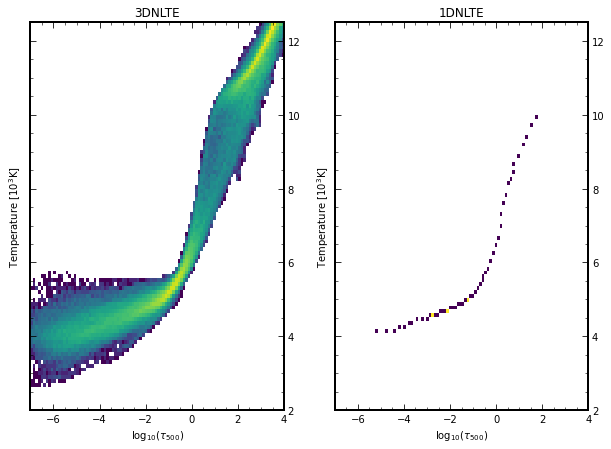

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10,7), sharey='row')
atmo_3DNLTE.hist2d(ax=ax[0]);
ax[0].set_title('3DNLTE')
atmo_1DNLTE.hist2d(ax=ax[1]);
ax[1].set_title('1DNLTE')

In [29]:
np.shape(atmo_3DNLTE.tau)

(30, 30, 230)

In [27]:
4*14

56

In [25]:
atmo_1DNLTE.tau[0]

memmap([[1.0000000e-10, 6.9560774e-06, 1.7611033e-05, 3.3903169e-05,
         5.9096616e-05, 9.7883945e-05, 1.5821549e-04, 2.5192124e-04,
         3.9773929e-04, 6.2500621e-04, 9.7969198e-04, 1.2156003e-03,
         1.5137303e-03, 1.8850870e-03, 2.3477245e-03, 2.9282991e-03,
         3.6516113e-03, 4.5592799e-03, 5.6981449e-03, 7.1167503e-03,
         8.8960398e-03, 1.1111154e-02, 1.3887354e-02, 1.7365005e-02,
         2.1688268e-02, 2.7096590e-02, 3.3856671e-02, 4.2241503e-02,
         5.2773602e-02, 6.5902546e-02, 8.2146510e-02, 1.0250608e-01,
         1.2786102e-01, 1.5931901e-01, 1.9859855e-01, 2.4753810e-01,
         3.0851743e-01, 3.8462713e-01, 4.7959453e-01, 5.9813321e-01,
         7.4617779e-01, 9.3088102e-01, 1.1610825e+00, 1.4476013e+00,
         1.8012187e+00, 2.2282851e+00, 2.7450020e+00, 3.3749588e+00,
         4.1460996e+00, 5.0943413e+00, 6.2692184e+00, 9.6049328e+00,
         1.4777386e+01, 2.2858110e+01, 3.5623020e+01, 5.5883762e+01],
        [1.0000000e-10, 6.9560774

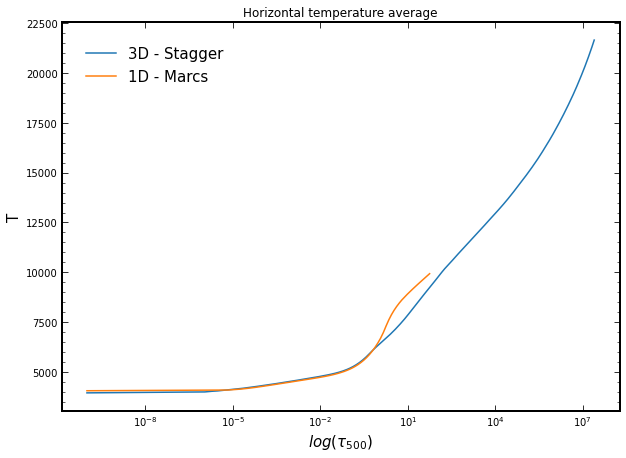

In [49]:
fig, ax = plt.subplots(1, figsize=(10,7), sharey='row')
ax.semilogx(atmo_3DNLTE.hav('tau'), atmo_3DNLTE.hav('temp'), label='3D - Stagger')
ax.semilogx(atmo_1DNLTE.hav('tau'), atmo_1DNLTE.hav('temp'), label='1D - Marcs')
ax.set_xlabel(r'$log(\tau_{500})$', fontsize=15)
ax.set_ylabel('T', fontsize=15)
ax.set_title('Horizontal temperature average against optical depth')
ax.legend(fontsize=15)

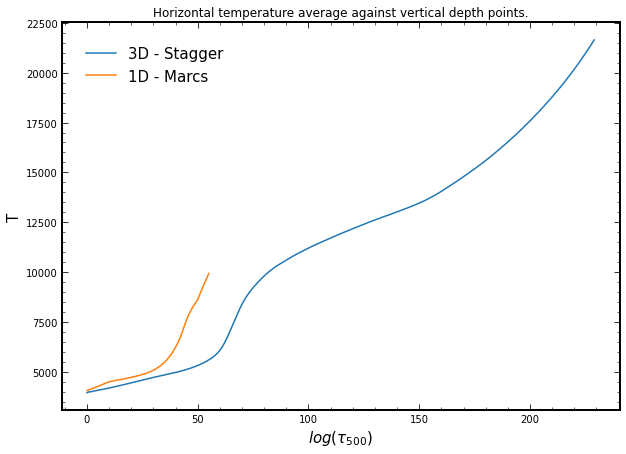

In [51]:
fig, ax = plt.subplots(1, figsize=(10,7), sharey='row')
ax.plot(atmo_3DNLTE.hav('temp'), label='3D - Stagger')
ax.plot(atmo_1DNLTE.hav('temp'), label='1D - Marcs')
ax.set_xlabel(r'$log(\tau_{500})$', fontsize=15)
ax.set_ylabel('T', fontsize=15)
ax.set_title('Horizontal temperature average against vertical depth points.')
ax.legend(fontsize=15)

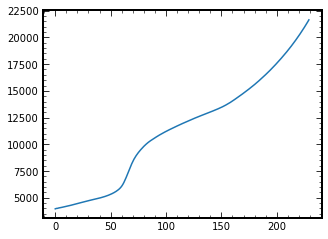

In [8]:
plt.plot(atmo_3DNLTE.hav('temp'))

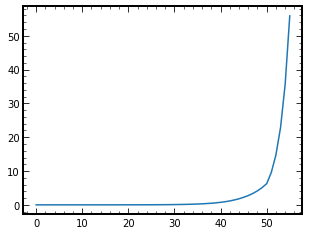

In [23]:
plt.plot(atmo_1DNLTE.hav('tau'))

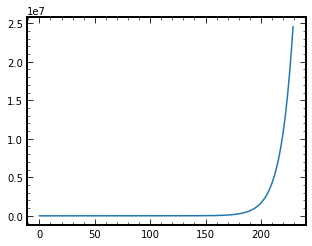

In [28]:
plt.plot(atmo_3DNLTE.hav('tau'))

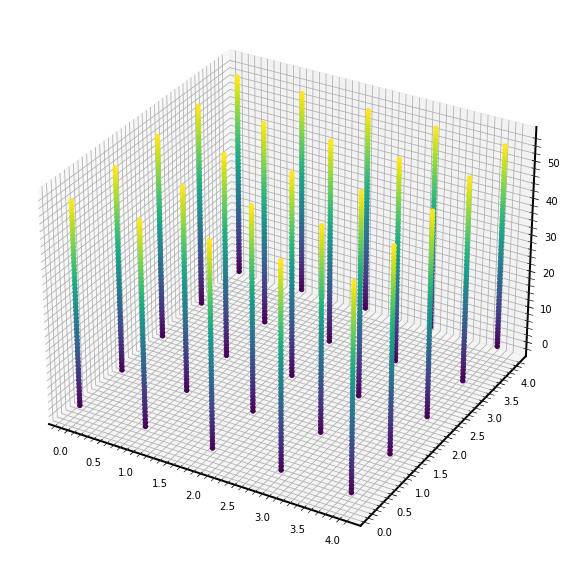

In [18]:
fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(111, projection='3d')
data = atmo_1DNLTE.temp
x, y, z = data.nonzero()
ax.scatter(x, y, z, c=z, alpha=1)

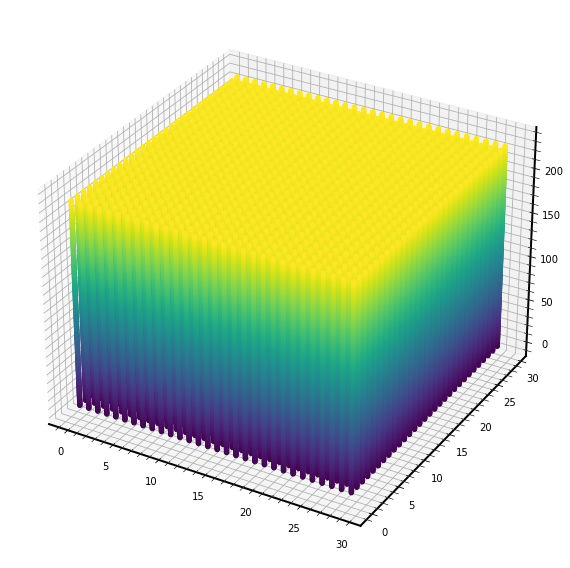

In [10]:
fig = plt.figure(figsize=(10,10))
ax= fig.add_subplot(111, projection='3d')
data = atmo_3DNLTE.tau
x, y, z = data.nonzero()
ax.scatter(x, y, z, c=z, alpha=1)